In [1]:
!pip install rohub

In [2]:

import rohub
import sys
import os
import pandas as pd

module_path = os.path.abspath(os.path.join('..', 'linear-elastic-plate-with-hole'))

if module_path not in sys.path:
    sys.path.append(module_path)
import importlib
import provenance
from generate_config import workflow_config

importlib.reload(provenance)

<module 'provenance' from '/Users/mahdi/Documents/HiWi (TIK)/NFDI4IngModelValidationPlatform/benchmarks/linear-elastic-plate-with-hole/provenance.py'>

In [3]:
USE_DEVELOPMENT_VERSION = False

In [4]:
if USE_DEVELOPMENT_VERSION:
    rohub.settings.API_URL = "https://rohub2020-rohub.apps.paas-dev.psnc.pl/api/"
    rohub.settings.KEYCLOAK_CLIENT_ID = "rohub2020-cli"
    rohub.settings.KEYCLOAK_CLIENT_SECRET = "714617a7-87bc-4a88-8682-5f9c2f60337d"
    rohub.settings.KEYCLOAK_URL = "https://keycloak-dev.apps.paas-dev.psnc.pl/auth/realms/rohub/protocol/openid-connect/token"
    rohub.settings.SPARQL_ENDPOINT = "https://rohub2020-api-virtuoso-route-rohub.apps.paas-dev.psnc.pl/sparql/"

In [ ]:
username = ""
password = ""

rohub.login(username=username, password=password)

Logged successfully as mahdi.jafarkhani@tik.uni-stuttgart.de.


In [21]:
ANNOTATION_PREDICATE = "http://w3id.org/nfdi4ing/metadata4ing#investigates"
ANNOTATION_OBJECT = "https://github.com/BAMresearch/NFDI4IngModelValidationPlatform/tree/main/benchmarks/linear-elastic-plate-with-hole"

In [22]:
RO  =  rohub.ros_load("43b04516-7492-4331-acd8-a78bb4640262")
annotation_json  = [
	{
		"property": ANNOTATION_PREDICATE,
		"value": ANNOTATION_OBJECT
	}
]
add_annotations_result = RO.add_annotations(body_specification_json=annotation_json)

print(add_annotations_result)

Research Object was successfully loaded with id = 43b04516-7492-4331-acd8-a78bb4640262
{'identifier': '6b28927a-5629-48ff-a4dd-a6ac34b0b8c6', 'shared_link': 'https://w3id.org/ro-id/43b04516-7492-4331-acd8-a78bb4640262/annotations/6b28927a-5629-48ff-a4dd-a6ac34b0b8c6', 'name': 'annotations/6b28927a-5629-48ff-a4dd-a6ac34b0b8c6', 'filename': '.ro/annotations/6b28927a-5629-48ff-a4dd-a6ac34b0b8c6.ttl', 'relation': False, 'read_only': False, 'target': '43b04516-7492-4331-acd8-a78bb4640262', 'ro': '43b04516-7492-4331-acd8-a78bb4640262', 'resources': [], 'created': '2025-11-30T16:26:25.146640+0000', 'creator': 'mahdi.jafarkhani@tik.uni-stuttgart.de', 'modificator': None, 'modified': '2025-11-30T16:26:25.146590+0000', 'is_dmp': True, 'is_system': False, 'api_link': 'https://api.rohub.org/api/annotations/6b28927a-5629-48ff-a4dd-a6ac34b0b8c6/'}


In [35]:
UUID_QUERY = f"""
SELECT ?subject 
WHERE {{
  ?subject <{ANNOTATION_PREDICATE}> <{ANNOTATION_OBJECT}> .
}}
"""

uuid_result = rohub.query_sparql_endpoint(UUID_QUERY)
uuids = []

if not uuid_result.empty:
    uuids = [iri.split('/')[-1] for iri in uuid_result["subject"]]
    print("UUIDs:", uuids)
else:
    uuids = []
    print("No results found")


UUIDs: ['43b04516-7492-4331-acd8-a78bb4640262', '1ec054b7-30a8-4f35-9b00-e2bba3891bc9', '0560bcb6-eab6-4660-becd-096caab71a4a']


In [20]:
import  rohub

research_areas  = ["Environmental research"]
title  =  "NFDI4ING Model Validation with NextFlow and Snakemake Using Fenics"
description  =  f"Description for {title}"
zip_path = "/Users/mahdi/Downloads/metadata4ing_provenance.zip"
result  =  rohub.ros_upload(path_to_zip=zip_path)

Trying to confirm status of the job. It can take a while...


In [42]:
named_graphs = {}

for UUID in uuids:
    NAMED_GRAPH_QUERY = f"""
    PREFIX schema: <http://schema.org/>
    SELECT ?graph WHERE {{
        GRAPH ?graph {{ <https://w3id.org/ro-id/{UUID}> a schema:Dataset . }}
    }}
    """

    named_graph_result = rohub.query_sparql_endpoint(NAMED_GRAPH_QUERY)

    if not named_graph_result.empty:
        graph_iri = named_graph_result.iloc[0]["graph"]
        named_graphs[UUID] = graph_iri
        print(f"[{UUID}] Found Named Graph: {graph_iri}")
    else:
        named_graphs[UUID] = None
        print(f"[{UUID}] No named graph found")

[43b04516-7492-4331-acd8-a78bb4640262] Found Named Graph: https://w3id.org/ro-id/43b04516-7492-4331-acd8-a78bb4640262/.ro/annotations/8ef5883f-3629-4160-b1e3-b77e01c8ffbc.ttl
[1ec054b7-30a8-4f35-9b00-e2bba3891bc9] Found Named Graph: https://w3id.org/ro-id/1ec054b7-30a8-4f35-9b00-e2bba3891bc9/.ro/annotations/99ec1727-c153-44eb-908d-fbbd7467561f.ttl
[0560bcb6-eab6-4660-becd-096caab71a4a] Found Named Graph: https://w3id.org/ro-id/0560bcb6-eab6-4660-becd-096caab71a4a/.ro/annotations/25f9cc6a-3435-4af5-81cf-14d972648b5c.ttl


In [53]:
analyzer = provenance.ProvenanceAnalyzer()

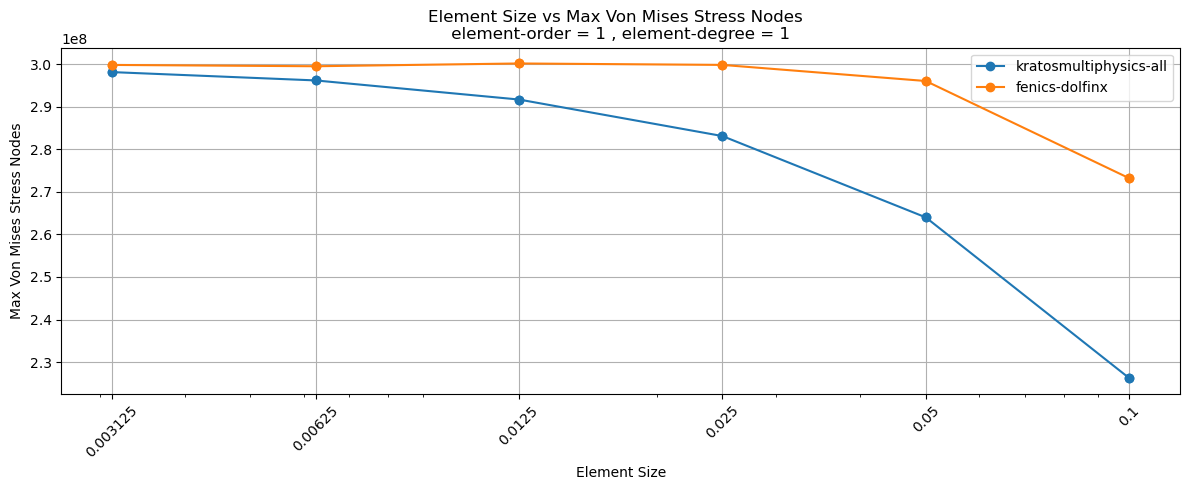

In [54]:
parameters = ["element_size", "element_order", "element_degree"]
metrics = ["max_von_mises_stress_nodes"]
tools = workflow_config["tools"]

data = []

for uuid, named_graph in named_graphs.items():
    query_string = analyzer.build_dynamic_query(parameters, metrics, tools, named_graph)
    result = rohub.query_sparql_endpoint(query_string)
    if not result.empty:
        result["element_order"] = pd.to_numeric(
            result["element_order"], errors="coerce"
        )
        result["element_degree"] = pd.to_numeric(
            result["element_degree"], errors="coerce"
        )
        filtered_result = result[
            (result["element_order"] == 1) & (result["element_degree"] == 1)
        ]
        rows = [
            [
                float(row["element_size"]),
                float(row["max_von_mises_stress_nodes"]),
                row["tool_name"],
            ]
            for _, row in filtered_result.iterrows()
        ]
        data.extend(rows)

data.sort(key=lambda row: row[0], reverse=False)

analyzer.plot_provenance_graph(
    data=data,
    x_axis_label="Element Size",
    y_axis_label="Max Von Mises Stress Nodes",
    x_axis_index=0,
    y_axis_index=1,
    group_by_index=2,
    title="Element Size vs Max Von Mises Stress Nodes  \n element-order = 1 , element-degree = 1 ",
)

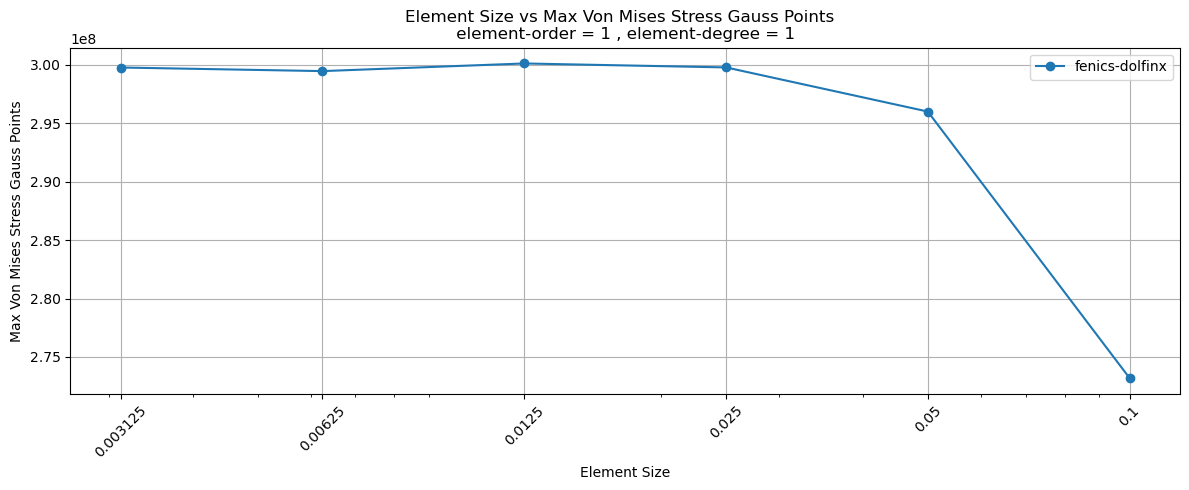

In [56]:
parameters = ["element_size", "element_order", "element_degree"]
metrics = ["max_von_mises_stress_gauss_points"]
tools = workflow_config["tools"]

data = []

for uuid, named_graph in named_graphs.items():
    query_string = analyzer.build_dynamic_query(parameters, metrics, tools, named_graph)
    result = rohub.query_sparql_endpoint(query_string)
    if not result.empty:
        result["element_order"] = pd.to_numeric(
            result["element_order"], errors="coerce"
        )
        result["element_degree"] = pd.to_numeric(
            result["element_degree"], errors="coerce"
        )
        filtered_result = result[
            (result["element_order"] == 1) & (result["element_degree"] == 1)
        ]
        rows = [
            [
                float(row["element_size"]),
                float(row["max_von_mises_stress_gauss_points"]),
                row["tool_name"],
            ]
            for _, row in filtered_result.iterrows()
        ]
        data.extend(rows)

data.sort(key=lambda row: row[0], reverse=False)

analyzer.plot_provenance_graph(
    data=data,
    x_axis_label="Element Size",
    y_axis_label="Max Von Mises Stress Gauss Points",
    x_axis_index=0,
    y_axis_index=1,
    group_by_index=2,
    title="Element Size vs Max Von Mises Stress Gauss Points  \n element-order = 1 , element-degree = 1 ",
)

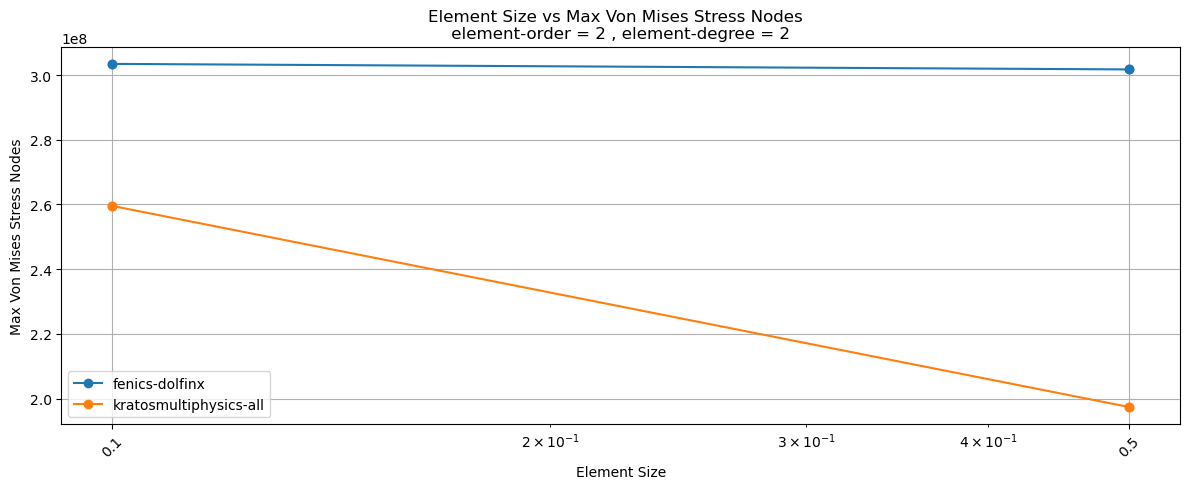

In [60]:
parameters = ["element_size", "element_order", "element_degree"]
metrics = ["max_von_mises_stress_nodes"]
tools = workflow_config["tools"]

data = []

for uuid, named_graph in named_graphs.items():
    query_string = analyzer.build_dynamic_query(parameters, metrics, tools, named_graph)
    result = rohub.query_sparql_endpoint(query_string)
    if not result.empty:
        result["element_order"] = pd.to_numeric(
            result["element_order"], errors="coerce"
        )
        result["element_degree"] = pd.to_numeric(
            result["element_degree"], errors="coerce"
        )
        filtered_result = result[
            (result["element_order"] == 2) & (result["element_degree"] == 2)
        ]
        rows = [
            [
                float(row["element_size"]),
                float(row["max_von_mises_stress_nodes"]),
                row["tool_name"],
            ]
            for _, row in filtered_result.iterrows()
        ]
        data.extend(rows)

data.sort(key=lambda row: row[0], reverse=False)

analyzer.plot_provenance_graph(
    data=data,
    x_axis_label="Element Size",
    y_axis_label="Max Von Mises Stress Nodes",
    x_axis_index=0,
    y_axis_index=1,
    group_by_index=2,
    title="Element Size vs Max Von Mises Stress Nodes  \n element-order = 2 , element-degree = 2 ",
)

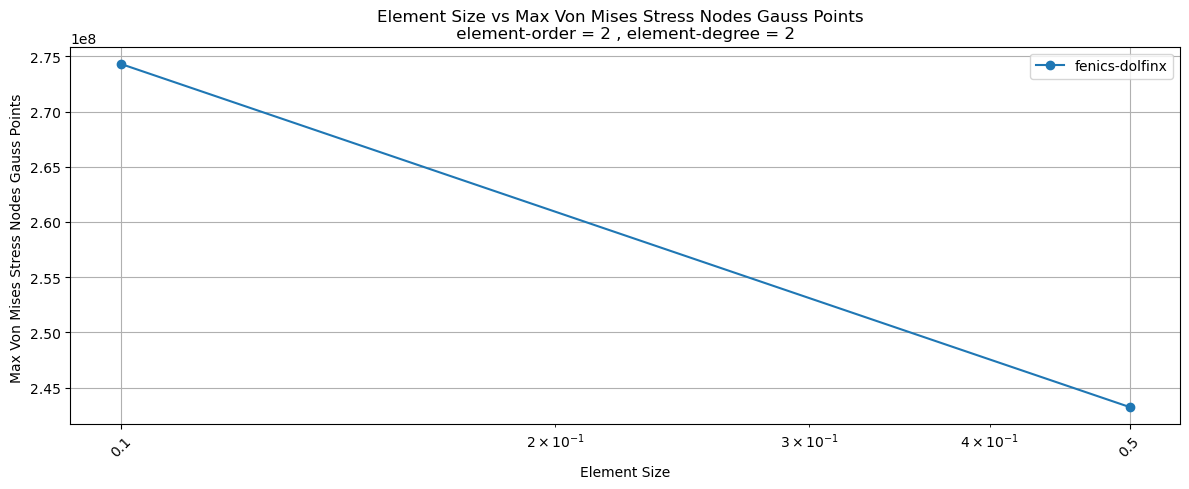

In [62]:
parameters = ["element_size", "element_order", "element_degree"]
metrics = ["max_von_mises_stress_gauss_points"]
tools = workflow_config["tools"]

data = []

for uuid, named_graph in named_graphs.items():
    query_string = analyzer.build_dynamic_query(parameters, metrics, tools, named_graph)
    result = rohub.query_sparql_endpoint(query_string)
    if not result.empty:
        result["element_order"] = pd.to_numeric(
            result["element_order"], errors="coerce"
        )
        result["element_degree"] = pd.to_numeric(
            result["element_degree"], errors="coerce"
        )
        filtered_result = result[
            (result["element_order"] == 2) & (result["element_degree"] == 2)
        ]
        rows = [
            [
                float(row["element_size"]),
                float(row["max_von_mises_stress_gauss_points"]),
                row["tool_name"],
            ]
            for _, row in filtered_result.iterrows()
        ]
        data.extend(rows)

data.sort(key=lambda row: row[0], reverse=False)

analyzer.plot_provenance_graph(
    data=data,
    x_axis_label="Element Size",
    y_axis_label="Max Von Mises Stress Nodes Gauss Points ",
    x_axis_index=0,
    y_axis_index=1,
    group_by_index=2,
    title="Element Size vs Max Von Mises Stress Nodes Gauss Points  \n element-order = 2 , element-degree = 2 ",
)